In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
warnings.simplefilter('ignore')

To load the hdmpy package which is used in the code below run the method below run from a jupyter notebook cell the code below
```
!pip install multiprocess
!pip install pyreadr
!git clone https://github.com/maxhuppertz/hdmpy.git
```

In [2]:
!pip install multiprocess
!pip install pyreadr
!git clone https://github.com/maxhuppertz/hdmpy.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.0/416.0 kB 9.5 MB/s eta 0:00:00
Cloning into 'hdmpy'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 70 (delta 39), reused 52 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 25.30 KiB | 12.65 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [3]:
import sys
sys.path.insert(1, "./hdmpy")
import hdmpy

In [4]:
# An estimator class that runs the lasso with theoretically driven penalty choice.
# Better in small samples than cross-validation and also faster computationally
class RLasso(BaseEstimator):

    def __init__(self, *, post=False):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    @property
    def coef_(self):
        return np.array(self.rlasso_.est['beta']).flatten()

    def predict(self, X):
        return X @ self.coef_ + np.array(self.rlasso_.est['intercept'])

In [259]:
import scipy.special
def gen_data(n, d, p, delta, base):
    X = np.random.uniform(-3, 3, size=(n, d))
    D = .5 * X[:, 0]**2 + np.random.normal(0, 1, size=(n,))
    y = delta * D + base - X[:, 0] + np.random.normal(0, 1, size=(n,))
    return y, D, X

In [260]:
# Now we simply replace OLS with Lasso to implement the Double Lasso process
def double_lasso(y, D, X):
    modely = RLasso().fit(X, y)
    yres = y - modely.predict(X) # residualize outcome with Lasso
    modeld = RLasso().fit(X, D)
    Dres = D - modeld.predict(X) # residualize treatment with Lasso
    # rest is the same as in the OLS case
    hat = np.mean(yres * Dres) / np.mean(Dres**2)
    epsilon = yres - hat * Dres
    V = np.mean(epsilon**2 * Dres**2) / np.mean(Dres**2)**2
    return hat, np.sqrt(V / y.shape[0])

In [261]:
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.base import BaseEstimator

class MyXGB(XGBRegressor):

    def fit(self, X, y):
        X, Xval, y, yval = train_test_split(X, y, test_size=0.2)
        super().fit(X, y, eval_set=[(Xval, yval)], verbose=False)
        return self

def generic_ml_model():
    return MyXGB(verbose=0, max_depth=3, min_child_weight=50, learning_rate=0.1, early_stopping_rounds=4)

def doubleml(y, D, X,
             modely=generic_ml_model(),
             modeld=generic_ml_model()):
    yres = y - cross_val_predict(modely, X, y, cv=5)
    Dres = D - cross_val_predict(modeld, X, D, cv=5)
    # rest is the same as in the OLS case
    hat = np.mean(yres * Dres) / np.mean(Dres**2)
    epsilon = yres - hat * Dres
    V = np.mean(epsilon**2 * Dres**2) / np.mean(Dres**2)**2
    return hat, np.sqrt(V / y.shape[0]), yres, Dres

In [270]:
np.random.seed(1234)
n = 10000
d = 10
delta = 1.0
base = 0.3
y, D, X = gen_data(n, d, .2, delta, base)
hat, stderr, yres, Dres = doubleml(y, D, X) # we apply the double lasso process
ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
hat, stderr, (ci[0] <= delta) & (delta <= ci[1])

(0.9872893566755738, 0.010118293671754494, True)

In [271]:
# R^2 for outcome and treatment model
1 - np.mean(yres**2 / np.var(y)), 1 - np.mean(Dres**2 / np.var(D))

(0.7068097795800947, 0.6415632797147914)

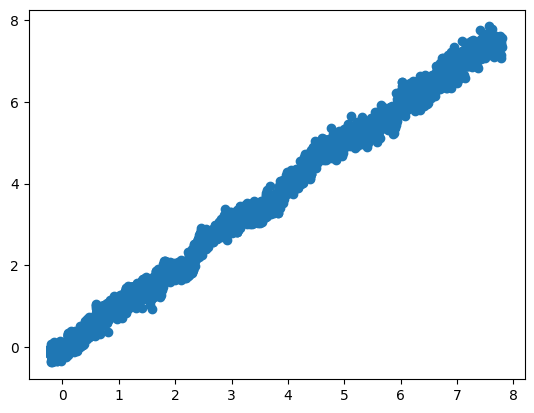

In [272]:
plt.scatter(delta * .5 * X[:, 0]**2 - X[:, 0] + base, y - yres)
plt.show()

In [273]:
# But let's try the Neyman orthogonal Double Lasso
from joblib import Parallel, delayed

def exp(it, n, d, delta=1.0, base=0.3):
    np.random.seed(it)
    y, D, X = gen_data(n, d, .2, delta, base)
    hat, stderr, yres, Dres = doubleml(y, D, X) # we apply the double lasso process
    ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
    return hat, stderr, (ci[0] <= delta) & (delta <= ci[1])

n = 10000
d = 10
res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, d) for it in range(100))
hats, stderrs, cov = zip(*res)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.3s finished


In [274]:
np.mean(cov) # great coverage

0.94

In [275]:
1 - np.mean(hats), np.std(hats) # very small bias compared to standard deviation

(0.006098027871111467, 0.009976320300885301)

In [276]:
np.mean(stderrs) # accurate estimation of uncertainty

0.010049644889040706

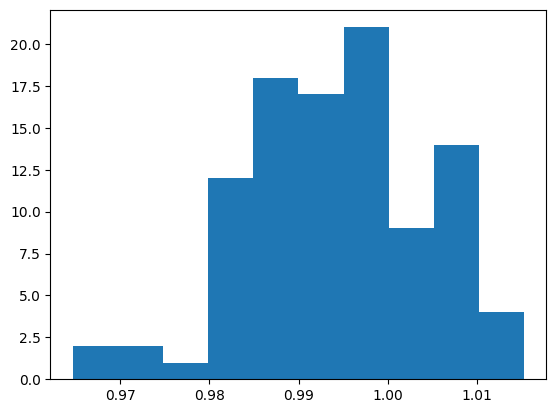

In [277]:
# Approximately normal distribution of estimates, centered at the truth
plt.hist(hats)
plt.show()